## **LG01 - Prediksi Dini Cacat Komponen Berdasarkan Inspeksi SPI - RISTEK FASILKOM UI DATATHON 2025**

---



Fokus utama dari modul ini adalah untuk membangun sebuah model yang mampu memprediksi secara dini apakah sebuah komponen akan diklasifikasikan sebagai cacat (Defect) atau tidak (Not Defect) oleh sistem Automatic Optical Inspection (AOI) di akhir lini produksi, dengan hanya menggunakan data dari tahap Solder Paste Inspection (SPI).

Keberhasilan model ini akan memberikan nilai bisnis yang signifikan, yaitu memungkinkan intervensi lebih awal untuk memperbaiki potensi masalah sebelum komponen dipasang, sehingga mengurangi jumlah produk gagal (scrap) dan beban kerja verifikasi manual oleh operator

## **Import Library & Dataset**

---



In [ ]:
!pip install catboost
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 246.9/246.9 kB 22.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, f1_score, confusion_matrix, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

**Upload kaggle.json**

Open Kaggle -> Settings -> Account -> API -> Create New Token -> Upload the file here

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
#!/bin/bash
!kaggle datasets download rizkyfadhilahjhhhh/dataset-lg01

Dataset URL: https://www.kaggle.com/datasets/rizkyfadhilahjhhhh/dataset-lg01
License(s): unknown
 93% 302M/323M [00:00<00:00, 463MB/s]
100% 323M/323M [00:00<00:00, 466MB/s]


In [ ]:
!unzip dataset-lg01.zip

Archive:  dataset-lg01.zip
  inflating: PCB Dataset/AOI_testing.csv  
  inflating: PCB Dataset/AOI_training.csv  
  inflating: PCB Dataset/SPI_testing_0.csv  
  inflating: PCB Dataset/SPI_testing_1.csv  
  inflating: PCB Dataset/SPI_training_0.csv  
  inflating: PCB Dataset/SPI_training_1.csv  
  inflating: PCB Dataset/SPI_training_2.csv  
  inflating: PCB Dataset/SPI_training_3.csv  


In [ ]:
aoi_train = pd.read_csv('/content/PCB Dataset/AOI_training.csv')
spi_0 = pd.read_csv('/content/PCB Dataset/SPI_training_0.csv')
spi_1 = pd.read_csv('/content/PCB Dataset/SPI_training_1.csv')
spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')
spi_3 = pd.read_csv('/content/PCB Dataset/SPI_training_3.csv')

merged_spi = pd.concat([spi_0, spi_1, spi_2, spi_3])

/tmp/ipython-input-6-2161004873.py:4: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  spi_2 = pd.read_csv('/content/PCB Dataset/SPI_training_2.csv')


## **Data Preprocessing & Feature Engineering**
_____________________________________________________

Proses ini mencakup:
- Pembersihan Data: Menyamakan tipe data pada kolom kunci untuk memastikan proses penggabungan berjalan lancar.

- Penggabungan Data: Melakukan left join dari data AOI ke data SPI untuk mendapatkan data akhir dari setiap komponen yang diinspeksi. Hanya data yang memiliki catatan di kedua sistem yang akan digunakan.

- Target Engineering: Membuat variabel target biner (target_1_is_defect) di mana 1 merepresentasikan cacat dan 0 sebaliknya.

- Feature Engineering: Membuat fitur-fitur baru yang lebih informatif berdasarkan wawasan dari EDA, seperti offset_magnitude untuk merepresentasikan total pergeseran dan fitur berbasis waktu (spi_hour, spi_dayofweek).

- Encoding: Mengubah fitur kategorikal seperti MachineID dan ComponentID menjadi format numerik yang dapat diproses oleh model.

In [ ]:
def preprocess_data(spi_df, aoi_df):
    for df in [spi_df, aoi_df]:
        for col in ['FigureID', 'PinNumber']:
            df[col] = pd.to_numeric(df[col], errors='coerce').astype('Int64')
    spi_df['Datetime'] = pd.to_datetime(spi_df['Date'] + ' ' + spi_df['Time'], errors='coerce')
    merged_cols = ["PanelID", "FigureID", "ComponentID", "PinNumber"]
    final_df = pd.merge(aoi_df, spi_df, on=merged_cols, how='left')
    final_df = final_df[final_df['Datetime'].notna()].copy()
    final_df['MachineID'] = final_df['MachineID'].astype('category').cat.codes
    final_df['Shape(um)'] = pd.to_numeric(final_df['Shape(um)'], errors='coerce')

    final_df['target_1_is_defect'] = (final_df['AOILabel'] != 'Soldered').astype(int)
    final_df['target_2_operator_bad'] = np.nan
    defect_mask = (final_df['target_1_is_defect'] == 1)
    final_df.loc[defect_mask, 'target_2_operator_bad'] = (final_df.loc[defect_mask, 'OperatorLabel'] == 'Bad').astype(int)
    final_df['target_3_repair_label'] = np.nan
    operator_bad_mask = (final_df['target_2_operator_bad'] == 1)
    if not final_df.loc[operator_bad_mask].empty:
        le = LabelEncoder()
        final_df.loc[operator_bad_mask, 'target_3_repair_label'] = le.fit_transform(final_df.loc[operator_bad_mask, 'RepairLabel'])

    final_df['spi_hour'] = final_df['Datetime'].dt.hour
    final_df['spi_dayofweek'] = final_df['Datetime'].dt.dayofweek
    final_df['spi_is_weekend'] = (final_df['spi_dayofweek'] >= 5).astype(int)
    final_df['offset_magnitude'] = np.sqrt(final_df['OffsetX(%)']**2 + final_df['OffsetY(%)']**2)
    final_df['volume_area_ratio'] = final_df['Volume(%)'] / (final_df['Area(%)'] + 1e-6)
    final_df['ComponentID_cat'] = final_df['ComponentID'].astype('category').cat.codes

    cols_to_drop = ['PanelID', 'FigureID', 'PinNumber', 'ComponentID', 'Date', 'Time', 'Datetime',
                    'AOILabel', 'OperatorLabel', 'RepairLabel', 'MachinePrediction', 'Result',
                    'Is_Defect', 'Is_Defect_Label', 'Volume(um3)', 'Area(um2)']
    final_cols_to_drop = [col for col in cols_to_drop if col in final_df.columns]
    final_df.drop(columns=final_cols_to_drop, inplace=True)

    return final_df


## **Optimasi Hyperparameter & Pelatihan**

---




Setelah mempersiapkan data, langkah selanjutnya adalah melatih model. Namun, daripada menggunakan hyperparameter default yang mungkin tidak optimal, kami menerapkan proses optimasi hyperparameter otomatis menggunakan Optuna.

In [ ]:
def train_best_model(model_type, X_train, y_train, X_val, y_val, n_classes, cat_features=None):
    def objective(trial):
        if model_type == 'lightgbm':
            params = {
                'objective': 'binary',
                'metric': 'f1',
                'verbosity': -1,
                'boosting_type': 'gbdt',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'scale_pos_weight': scale_pos_weight_value,
            }
            model = lgb.LGBMClassifier(**params)
        elif model_type == 'xgboost':
            params = {
                'objective': 'binary:logistic',
                'eval_metric': 'logloss',
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'max_depth': trial.suggest_int('max_depth', 3, 10),
                'scale_pos_weight': scale_pos_weight_value,
                'n_estimators': 100
            }
            model = xgb.XGBClassifier(**params, use_label_encoder=False)
        elif model_type == 'catboost':
            params = {
                'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
                'depth': trial.suggest_int('max_depth', 3, 10),
                'verbose': 0,
                'scale_pos_weight': scale_pos_weight_value
            }
            model = cb.CatBoostClassifier(**params)
        else:
            raise ValueError("Invalid model type")

        if model_type == 'catboost' and cat_features is not None:
            model.fit(X_train, y_train, cat_features=cat_features)
        else:
            model.fit(X_train, y_train)

        preds = model.predict(X_val)
        return f1_score(y_val, preds, average='macro')

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=20)
    best_params = study.best_params
    if model_type == 'lightgbm':
        return lgb.LGBMClassifier(**best_params).fit(X_train, y_train)
    elif model_type == 'xgboost':
        return xgb.XGBClassifier(**best_params, use_label_encoder=False).fit(X_train, y_train)
    else:
        return cb.CatBoostClassifier(**best_params).fit(X_train, y_train, cat_features=cat_features)


## **Pendekatan Alternatif: LSTM**

---



In [ ]:
class PCBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, i): return self.X[i], self.y[i]

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.lstm = nn.LSTM(input_size, 64, batch_first=True)
        self.fc = nn.Linear(64, output_size)
    def forward(self, x):
        x = x.unsqueeze(1)
        _, (hn, _) = self.lstm(x)
        return self.fc(hn[-1])

In [ ]:
def train_lstm(X_train, y_train, X_val, y_val, n_classes):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)

    train_loader = DataLoader(PCBDataset(pd.DataFrame(X_train_scaled), y_train), batch_size=64, shuffle=True)
    val_loader = DataLoader(PCBDataset(pd.DataFrame(X_val_scaled), y_val), batch_size=64)

    model = LSTMClassifier(input_size=X_train.shape[1], output_size=n_classes)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()

    best_val_loss = float('inf')
    patience, counter = 3, 0

    for epoch in range(100):
        model.train()
        for xb, yb in train_loader:
            optimizer.zero_grad()
            loss = loss_fn(model(xb), yb)
            loss.backward()
            optimizer.step()

        model.eval()
        val_losses = []
        with torch.no_grad():
            for xb, yb in val_loader:
                loss = loss_fn(model(xb), yb)
                val_losses.append(loss.item())

        avg_val = np.mean(val_losses)
        print(f"Epoch {epoch+1}, Val Loss: {avg_val:.4f}")

        if avg_val < best_val_loss:
            best_val_loss = avg_val
            torch.save(model.state_dict(), "best_lstm.pt")
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

    model.load_state_dict(torch.load("best_lstm.pt"))
    return model, scaler, X_val_scaled

## **Fungsi Evaluasi Model**

---



In [ ]:
def evaluate_model(y_true, y_pred, name, label_names=None):
    print(f"\n=== {name} ===")
    print(classification_report(y_true, y_pred, target_names=label_names))

    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d',
                xticklabels=label_names,
                yticklabels=label_names,
                cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


## **Persiapan Data untuk Pemodelan**

---



In [ ]:
model_ready_df = preprocess_data(merged_spi, aoi_train)

X = model_ready_df.drop(columns=['target_1_is_defect', 'target_2_operator_bad', 'target_3_repair_label'])
y = model_ready_df['target_1_is_defect']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
n_classes = len(np.unique(y))
labels = y.unique()
scale_pos_weight_value = y_train.value_counts()[0] / y_train.value_counts()[1]

## **Pelatihan dan Optimasi Model**

---



In [ ]:
cat_features = [X.columns.get_loc('MachineID'), X.columns.get_loc('ComponentID_cat')]
cat_model = train_best_model('catboost', X_train, y_train, X_val, y_val, n_classes, cat_features)
lgb_model = train_best_model('lightgbm', X_train, y_train, X_val, y_val, n_classes)
xgb_model = train_best_model('xgboost', X_train, y_train, X_val, y_val, n_classes)
lstm_model, scaler_lstm, X_val_scaled = train_lstm(X_train, y_train, X_val, y_val, n_classes)

[I 2025-07-09 06:33:51,025] A new study created in memory with name: no-name-10c3ae48-4dab-484a-a508-71d3fa746b25
[I 2025-07-09 06:34:17,947] Trial 0 finished with value: 0.9212925233427247 and parameters: {'learning_rate': 0.0625254225224151, 'max_depth': 7}. Best is trial 0 with value: 0.9212925233427247.
[I 2025-07-09 06:34:42,006] Trial 1 finished with value: 0.9124727914813187 and parameters: {'learning_rate': 0.2507210632561904, 'max_depth': 6}. Best is trial 0 with value: 0.9212925233427247.
[I 2025-07-09 06:36:04,927] Trial 2 finished with value: 0.9115184082062318 and parameters: {'learning_rate': 0.13732709200510657, 'max_depth': 10}. Best is trial 0 with value: 0.9212925233427247.
[I 2025-07-09 06:36:31,408] Trial 3 finished with value: 0.9092982295143199 and parameters: {'learning_rate': 0.23090969414415768, 'max_depth': 7}. Best is trial 0 with value: 0.9212925233427247.
[I 2025-07-09 06:36:51,515] Trial 4 finished with value: 0.922447448385246 and parameters: {'learning_r

0:	learn: 0.6638639	total: 14.5ms	remaining: 14.5s
1:	learn: 0.6345722	total: 28.6ms	remaining: 14.2s
2:	learn: 0.6172621	total: 47.2ms	remaining: 15.7s
3:	learn: 0.5939493	total: 76.7ms	remaining: 19.1s
4:	learn: 0.5694065	total: 89.7ms	remaining: 17.9s
5:	learn: 0.5474106	total: 103ms	remaining: 17.1s
6:	learn: 0.5259469	total: 117ms	remaining: 16.6s
7:	learn: 0.5060895	total: 130ms	remaining: 16.1s
8:	learn: 0.4890728	total: 143ms	remaining: 15.8s
9:	learn: 0.4720656	total: 158ms	remaining: 15.6s
10:	learn: 0.4558420	total: 170ms	remaining: 15.3s
11:	learn: 0.4411688	total: 186ms	remaining: 15.3s
12:	learn: 0.4275266	total: 200ms	remaining: 15.2s
13:	learn: 0.4154449	total: 217ms	remaining: 15.3s
14:	learn: 0.4042010	total: 232ms	remaining: 15.2s
15:	learn: 0.3940625	total: 246ms	remaining: 15.1s
16:	learn: 0.3850132	total: 259ms	remaining: 15s
17:	learn: 0.3758266	total: 273ms	remaining: 14.9s
18:	learn: 0.3669790	total: 286ms	remaining: 14.8s
19:	learn: 0.3587896	total: 299ms	rema

[I 2025-07-09 06:42:59,839] A new study created in memory with name: no-name-0ceab389-4d10-4905-b637-f0f97a5a87cf


995:	learn: 0.1395863	total: 16.9s	remaining: 67.8ms
996:	learn: 0.1395701	total: 16.9s	remaining: 50.9ms
997:	learn: 0.1395618	total: 16.9s	remaining: 34ms
998:	learn: 0.1395541	total: 17s	remaining: 17ms
999:	learn: 0.1395398	total: 17s	remaining: 0us


[I 2025-07-09 06:43:00,302] Trial 0 finished with value: 0.9116471737832279 and parameters: {'learning_rate': 0.2403582940421499, 'max_depth': 9}. Best is trial 0 with value: 0.9116471737832279.
[I 2025-07-09 06:43:00,627] Trial 1 finished with value: 0.9130177457694175 and parameters: {'learning_rate': 0.23325353925680617, 'max_depth': 8}. Best is trial 1 with value: 0.9130177457694175.
[I 2025-07-09 06:43:00,870] Trial 2 finished with value: 0.9325337401889676 and parameters: {'learning_rate': 0.28458869679984694, 'max_depth': 4}. Best is trial 2 with value: 0.9325337401889676.
[I 2025-07-09 06:43:01,196] Trial 3 finished with value: 0.9308000874020559 and parameters: {'learning_rate': 0.10345349394428084, 'max_depth': 8}. Best is trial 2 with value: 0.9325337401889676.
[I 2025-07-09 06:43:01,539] Trial 4 finished with value: 0.927135314567096 and parameters: {'learning_rate': 0.1740520710801797, 'max_depth': 6}. Best is trial 2 with value: 0.9325337401889676.
[I 2025-07-09 06:43:01,

Epoch 1, Val Loss: 0.2450
Epoch 2, Val Loss: 0.2326
Epoch 3, Val Loss: 0.2188
Epoch 4, Val Loss: 0.2075
Epoch 5, Val Loss: 0.2012
Epoch 6, Val Loss: 0.1992
Epoch 7, Val Loss: 0.1962
Epoch 8, Val Loss: 0.1910
Epoch 9, Val Loss: 0.1914
Epoch 10, Val Loss: 0.1905
Epoch 11, Val Loss: 0.1890
Epoch 12, Val Loss: 0.1850
Epoch 13, Val Loss: 0.1845
Epoch 14, Val Loss: 0.1830
Epoch 15, Val Loss: 0.1824
Epoch 16, Val Loss: 0.1818
Epoch 17, Val Loss: 0.1808
Epoch 18, Val Loss: 0.1815
Epoch 19, Val Loss: 0.1798
Epoch 20, Val Loss: 0.1790
Epoch 21, Val Loss: 0.1791
Epoch 22, Val Loss: 0.1786
Epoch 23, Val Loss: 0.1765
Epoch 24, Val Loss: 0.1764
Epoch 25, Val Loss: 0.1756
Epoch 26, Val Loss: 0.1778
Epoch 27, Val Loss: 0.1782
Epoch 28, Val Loss: 0.1752
Epoch 29, Val Loss: 0.1752
Epoch 30, Val Loss: 0.1746
Epoch 31, Val Loss: 0.1740
Epoch 32, Val Loss: 0.1744
Epoch 33, Val Loss: 0.1732
Epoch 34, Val Loss: 0.1737
Epoch 35, Val Loss: 0.1730
Epoch 36, Val Loss: 0.1737
Epoch 37, Val Loss: 0.1725
Epoch 38, 

## **Evaluasi dan Perbandingan Model**


=== CatBoost ===
                precision    recall  f1-score   support

Not Defect (0)       0.90      0.97      0.93      1882
    Defect (1)       0.98      0.92      0.95      2625

      accuracy                           0.94      4507
     macro avg       0.94      0.95      0.94      4507
  weighted avg       0.94      0.94      0.94      4507



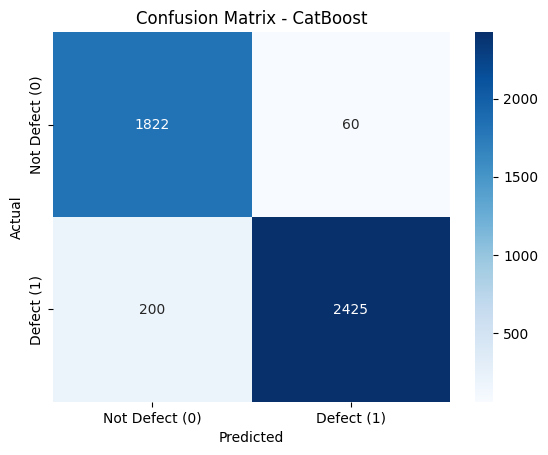


=== LightGBM ===
                precision    recall  f1-score   support

Not Defect (0)       0.90      0.97      0.93      1882
    Defect (1)       0.98      0.92      0.95      2625

      accuracy                           0.94      4507
     macro avg       0.94      0.95      0.94      4507
  weighted avg       0.94      0.94      0.94      4507



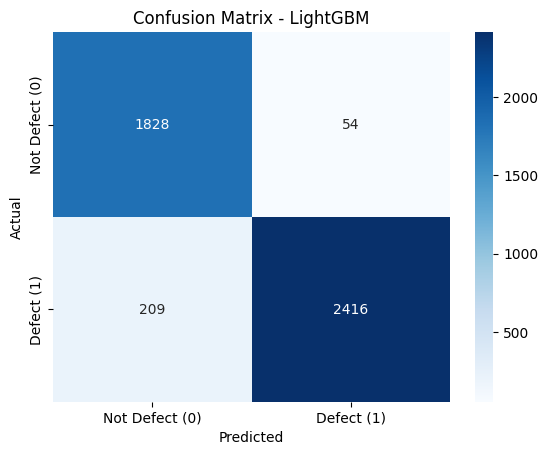


=== XGBoost ===
                precision    recall  f1-score   support

Not Defect (0)       0.90      0.97      0.93      1882
    Defect (1)       0.98      0.92      0.95      2625

      accuracy                           0.94      4507
     macro avg       0.94      0.95      0.94      4507
  weighted avg       0.95      0.94      0.94      4507



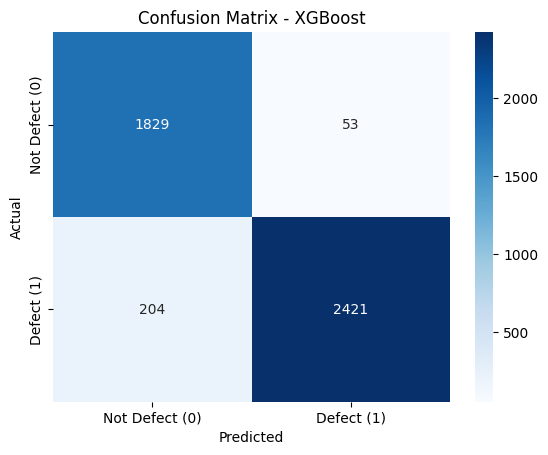


=== LSTM ===
                precision    recall  f1-score   support

Not Defect (0)       0.88      0.95      0.92      1882
    Defect (1)       0.96      0.91      0.93      2625

      accuracy                           0.93      4507
     macro avg       0.92      0.93      0.93      4507
  weighted avg       0.93      0.93      0.93      4507



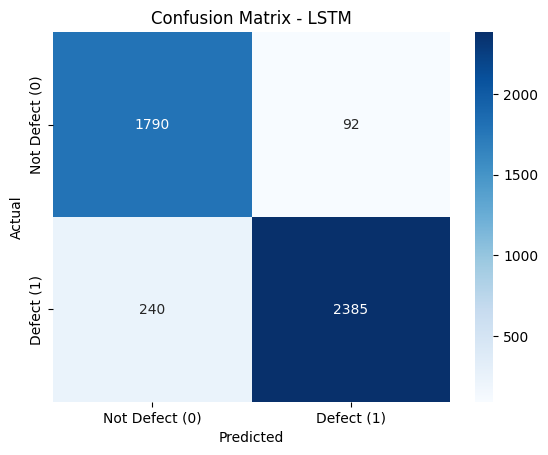

In [ ]:
label_names = ["Not Defect (0)", "Defect (1)"]
evaluate_model(y_val, cat_model.predict(X_val), "CatBoost", label_names)
evaluate_model(y_val, lgb_model.predict(X_val), "LightGBM", label_names)
evaluate_model(y_val, xgb_model.predict(X_val), "XGBoost", label_names)
lstm_model.eval()
with torch.no_grad():
    tensor_val = torch.tensor(X_val_scaled, dtype=torch.float32)
    preds_lstm = lstm_model(tensor_val)
    lstm_preds = torch.argmax(preds_lstm, dim=1).numpy()
evaluate_model(y_val, lstm_preds, "LSTM", label_names)

## **Download LightGBM Model dalam format .pkl**

Alasan memilih LightGBM karena LightGBM secara umum dikenal sebagai yang tercepat di antara ketiganya dengan performa yang sebanding dengan CatBoost, XGBoost

In [ ]:
model_filename = 'Task1_model_is_defect_lightgbm.pkl'
joblib.dump(lgb_model, model_filename)

['Task1_model_is_defect_lightgbm.pkl']